In [1]:
from IPython.display import Image

# Using ehrapy with large datasets

Modern health datasets can become very large. When datasets are so large they cannot be loaded into a computer's memory at once, loading and processing the data in batches becomes necessary. This is also called doing the computations "out-of-core".

[`dask`](https://www.dask.org) is a popular out-of-core, distributed array processing library that ehrapy is beginning to support.  Here we walk through a quick tutorial of using `dask` in a simple analysis task.

:::{warning} 🔪 **Beware sharp edges!** 🔪

`dask` support in `ehrapy`, leveraging `scanpy` functionality, is new and highly experimental!

Many functions in `ehrapy` **do not** support `dask` and may exhibit unexpected behaviour if dask arrays are passed to them. Stick to what's outlined in this tutorial and you should be fine!

Please report any issues you run into over on the issue tracker.
:::

## Setup

This notebook relies on optional dependencies in dask. Install them with:

```sh
pip install -U "dask[array,distributed,diagnostics]" dask-ml
```

We profile the memory usage of functions, for which we will use scalene. Install scalene with:

```sh
pip install scalene
```

In [1]:
%load_ext autoreload
%autoreload 2

In [4]:
from pathlib import Path

import numpy as np
import dask.distributed as dd
import dask.array as da
from sklearn.datasets import make_blobs
import ehrapy as ep
import anndata as ad


## Example Usecase


We can now profile the required time and memory consumption of two runs for processing this data:
1. In memory (which is feasible with our demo dataset)
2. Out-of-core

We will be using scalene as our profiler here.

For this, in your command line within this environment the two respective python scripts can now be run with 

```
scalene profile_memory.py --outfile profile_memory.html
```
for the in-memory computation and 

```
scalene profile_out_of_core.py --outfile profile_out_of_core.html
```
for the out-of-core computation.

To compare the two approaches, the following and preprocessing and exploratory workflow is profiled, for a synthetic dataset of 50'000 samples and 1'000 features, with 4 distinct groups underlying the data generation process.

```py

# generate dummy data
adata = ...

# inferring feature types
ep.ad.infer_feature_types(adata)

# scaling the data to 0 mean and unit variance
ep.pp.scale_norm(adata)

# computing a pca
ep.pp.pca(adata)

# compute a nearest neighbor graph on pca space
ep.pp.neighbors(adata)

# compute leiden clustering
ep.tl.leiden(adata)

# create and save a plot of the pca, cluster the points by leiden cluster label
ep.pl.pca(adata, color="leiden", save="...")
```

### Results

The resulting Scalene profiles obtained look roughly like this, and can depend on the machine and environment the profiling is run.

#### In Memory Profile


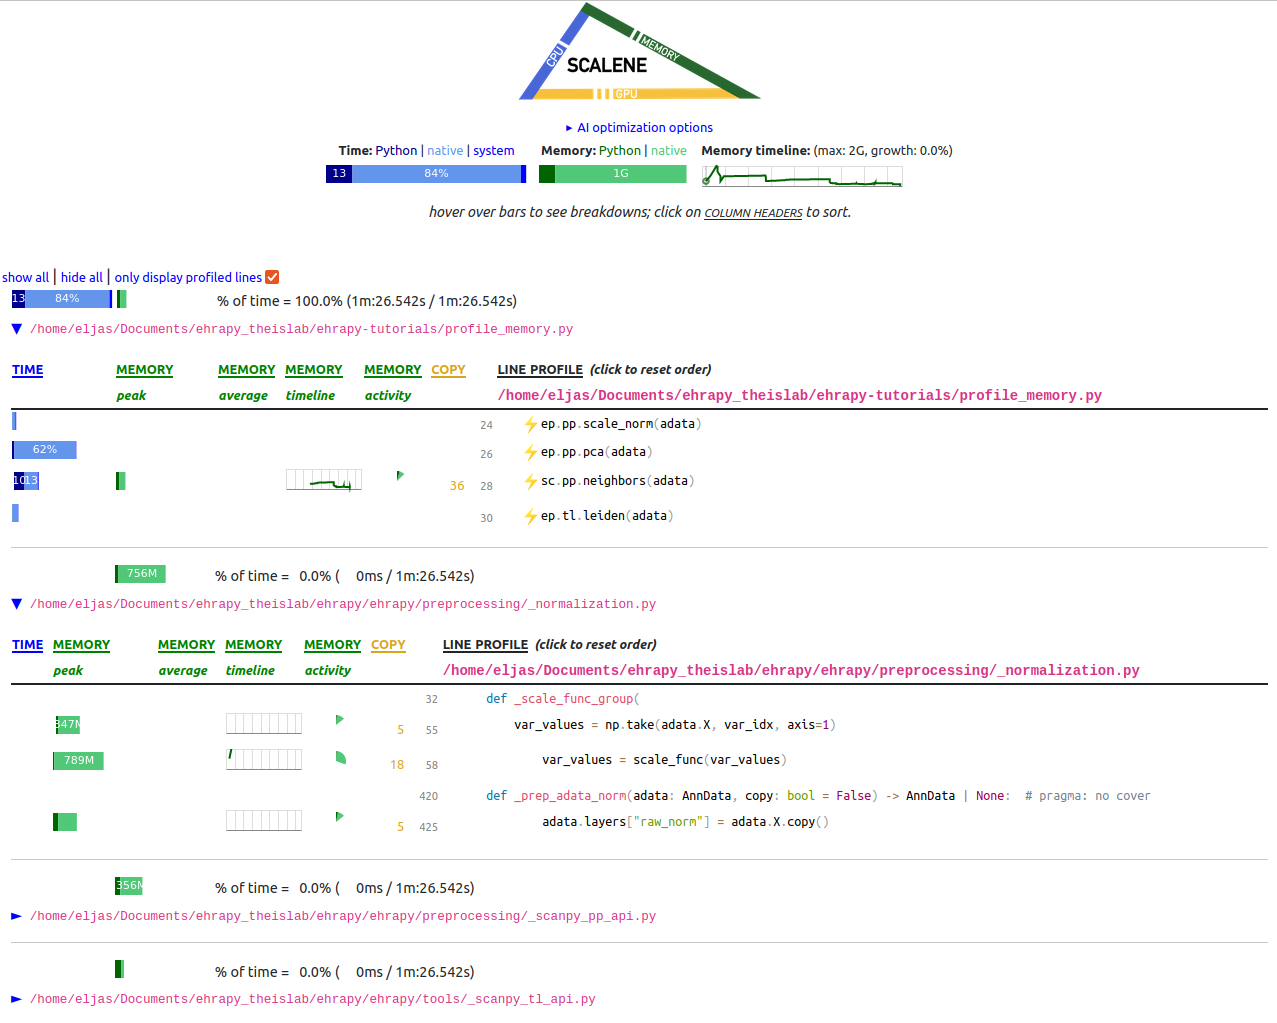

In [2]:
Image(filename="images/memory_profile_50000x1000.png", width=800)

#### Out-of-core Profile


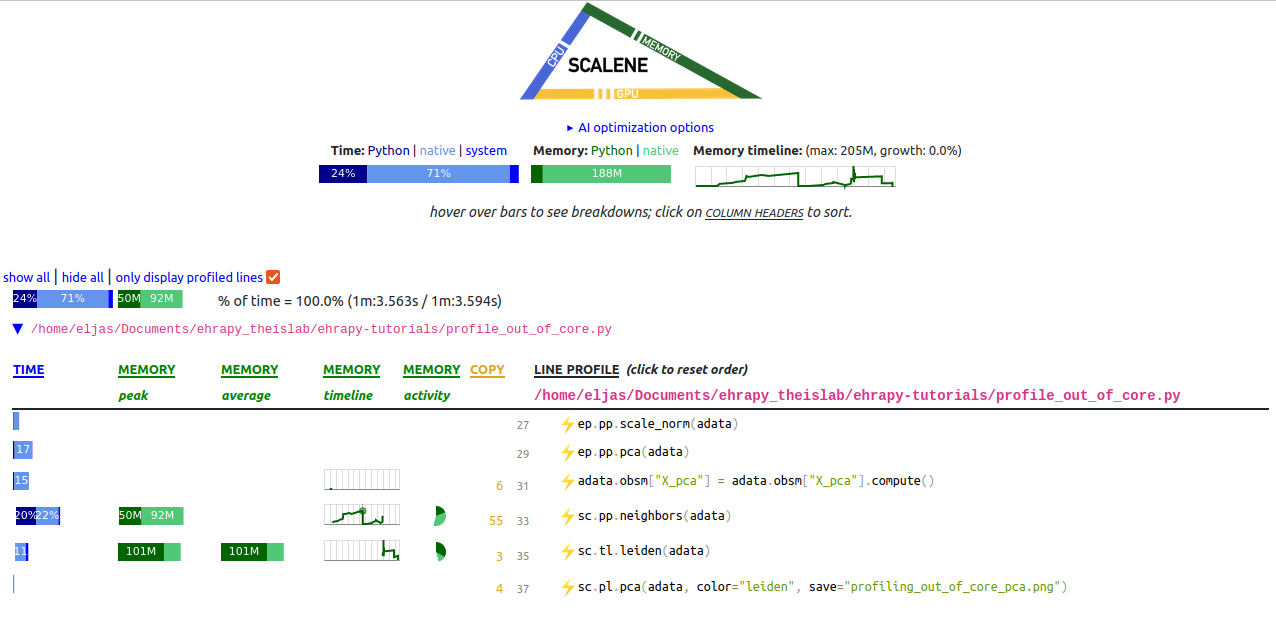

In [3]:
Image(filename="images/out_of_core_profile_50000x1000.png", width=800)

There are multiple features in `scalene`'s output, we focus on the key aspects here:

##### Time
The required time for the profiled code to execute is displayed at the topmost "% of time = 100.0%". We can see that for the in-memory computation, the required wall time was 1 min 26 seconds, whereas for the out-of-core computation, the required wall time was 1 min 3 seconds.

Generally, the out-of-core computation can yield performance improvements by optimizing the scheduling of computations by using "lazy execution", for which you can find more information here. Dask also allows distributed computations, providing even further speed improvements.

However, the overhead of such out-of-core computations can also quickly exceed the gains obtained, see here for a more detailed discussion.

Here, we can see that the order of magnitude for execution time for both workflows is similar.

##### Maximum Memory Consumption
The maximum required memory for the profiled code is displayed at the top right, on top of the Memory timeline plot.
We can see that the maximum memory occupation for the in-memory computation was 2GB, whereas for the out-of-core computation, the maximum memory occupation was 205MB.

This can be achieved by leveraging the key idea behind dask, its block-wise ("chunked") computations. This means that dask accesses the data in chunks, not requiring the entire dataset to be loaded to memory at once.
The size of the blocks is a tradeoff of having not too many small blocks (causing too much overhead) and not too big blocks (causing increased memory consumption and potentially less distributed computations). See here for a more detailed discussion on the block size.

We can also inspect the memory consumption of individual function calls with scalene; for more details on profiling, we refer to scalene's documentation.

#### Conclusion
Here, we show with synthetic dataset how out-of-core computations can improve the performance and reduce the memory requirements for a suite of analysis steps.

The dataset we have generated is small enough to not require out-of-core computations, so we can compare the in-memory and the out-of-core computation profiles.

In general, in-memory computations are to be preferred whenever they are feasible, being easier to perform and omit potential pitfals such as using too small chunk sizes.

We have computed a PCA and can observe that the four underlying groups in our synthetic data form well separated clusters in the two-dimensional PCA projection, and are well clustered by Leiden clustering. 

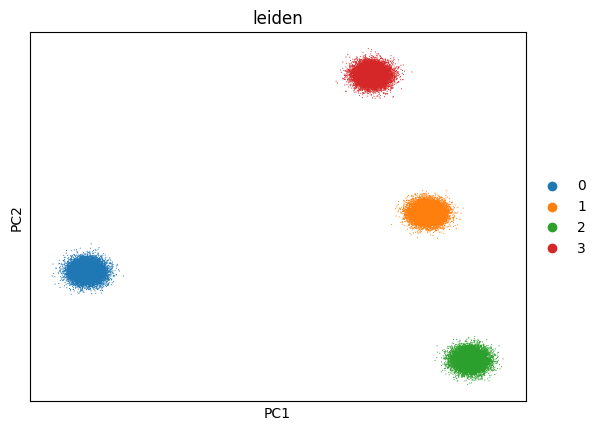

In [4]:
Image(filename="images/pcaprofiling_out_of_core_pca.png", width=800)

We can also inspect our computed UMAP:



For this synthetic dataset, the 4 groups generated can readily be retrieved and represented in lower-dimensional spaces.

Further support for `dask` is a work in progress. However, many operations past this point can work with the dimensionality reduction directly in memory.